In [1]:
#importing helping hands
import os
import time
from collections import Counter

import pandas as pd
import numpy as np

pd.set_option('display.float_format', lambda x: '%.2f' % x)

from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings('ignore')

import category_encoders as ce
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import confusion_matrix, f1_score

In [2]:
train_path = '../input/credit-risk-dataset/loan/loan.csv'
data = pd.read_csv(train_path)

In [3]:
data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.00,5000.00,4975.00,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.00,2500.00,2500.00,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.00,2400.00,2400.00,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000.00,10000.00,10000.00,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000.00,3000.00,3000.00,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
data['loan_status'].unique()

array(['Fully Paid', 'Charged Off', 'Current', 'Default',
       'Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off', 'Issued'],
      dtype=object)

#### Loan Status
Before Getting into feature engineering lets understand about the loan status. I have created 4 different categories for given statuses.

1. **Issued**
    * Recently issued a fresh loan to borrower
2. **Issued, Current, Fully Paid, Does not meet the credit policy. Status:Fully Paid (Category 1)**
    * Current - All outstanding payments are paid up to date 
    * Fully Paid - All outstanding payments are paid up and loan is finished
3. **In Grace Period, Late (16-30 days), Late (31-120 days) (Category 2)**
    * In Grace Period - 1-15 days passed after the due date
    * Late (16-30 days) - 16-30 days passed after the due date
    * Late (31-120 days) - 31-120 days passed after the due date
4. **Charged Off , Does not meet the credit policy. Status:Charged Off, Default (Category 3)**
    * Default - The borrower is not able to make outstanding payments for an extended period of time
    * Charged Off - A charge-off usually occurs when the creditor has deemed an outstanding debt is uncollectible
    
Inorder to get idea about the different loan status, please visit https://bit.ly/35Vv3W3

## Normal Random Forest

In [5]:
#copying the dataframe
df = data.copy()

In [6]:
#removing columns havinf more than 97% NaNs 
columns = []
for column in df.columns:
    if ((df[column].isna().sum()/len(df))*100) >= 97:
        columns.append(column)
df.drop(columns = columns, axis = 1, inplace = True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 57 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           887379 non-null  int64  
 1   member_id                    887379 non-null  int64  
 2   loan_amnt                    887379 non-null  float64
 3   funded_amnt                  887379 non-null  float64
 4   funded_amnt_inv              887379 non-null  float64
 5   term                         887379 non-null  object 
 6   int_rate                     887379 non-null  float64
 7   installment                  887379 non-null  float64
 8   grade                        887379 non-null  object 
 9   sub_grade                    887379 non-null  object 
 10  emp_title                    835917 non-null  object 
 11  emp_length                   842554 non-null  object 
 12  home_ownership               887379 non-null  object 
 13 

In [8]:
#fillna in dataframe
df.fillna(0, inplace = True)

In [9]:
#dividing the loan_statuses into 3 categories
df.loc[df['loan_status'].isin(['Issued','Current','Does not meet the credit policy. Status:Fully Paid', 'Fully Paid']), 'loan_category'] = 1
df.loc[df['loan_status'].isin(['In Grace Period', 'Late (16-30 days)', 'Late (31-120 days)']), 'loan_category'] = 2
df.loc[df['loan_status'].isin(['Charged Off' , 'Does not meet the credit policy. Status:Charged Off', 'Default']), 'loan_category'] = 3

#droping the loan_status column 
df.drop(['loan_status'], axis = 1, inplace = True)

#object type columns 
object_columns = df.select_dtypes('object')

#separating the features and labels
features = df.drop(columns = ['loan_category'], axis = 1)
labels = df['loan_category']

#train-test spliting
X_train, X_test, y_train, y_test =  train_test_split(features, labels, test_size = 0.25, random_state = 43, stratify = labels)

In [10]:
def category_encoding(columns, X_train, X_test):
    #encoding the categorical data
    encoder = ce.OrdinalEncoder(cols = columns)
    encoder = encoder.fit(X_train)

    X_train_encoded = encoder.transform(X_train)
    X_test_encoded = encoder.transform(X_test)
    
    return X_train_encoded, X_test_encoded

In [11]:
def training_predicting(X_train, X_test, y_train, n, imp_features = False):
    #selecting random forest for training
    model = RandomForestClassifier(n_estimators = n, verbose = 1)

    #training
    model.fit(X_train, y_train)

    #prediction and metrix score
    y_predict = model.predict(X_test)
    
    if imp_features == True:
        return y_predict, model.feature_importances_
    
    return y_predict

In [12]:
#categorical encoding
X_train_encoded, X_test_encoded = category_encoding(object_columns, X_train, X_test)

#training, predicting, feature importance  
y_predict, imp_features = training_predicting(X_train_encoded, X_test_encoded, y_train, 20, imp_features = True)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.4s finished


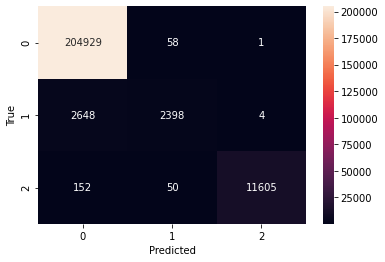

In [13]:
#confusion matrix
cf_matrix = confusion_matrix(y_test, y_predict, labels = [1,2,3])
sns.heatmap(cf_matrix, annot=True, fmt = 'g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [14]:
#10 important features
imp_features = pd.DataFrame(imp_features, index = X_train.columns, columns = ['importance']).sort_values('importance', ascending = False)
imp_features.head(10)

,importance
recoveries,0.14
last_pymnt_d,0.13
collection_recovery_fee,0.10
total_rec_prncp,0.09
last_pymnt_amnt,0.05
total_pymnt,0.04
funded_amnt,0.04
next_pymnt_d,0.03
funded_amnt_inv,0.03
id,0.03


## Feature Creation

In [15]:
#copying the dataframe
df = data.copy()

In [16]:
#removing columns havinf more than 97% NaNs 
columns = []
for column in df.columns:
    if ((df[column].isna().sum()/len(df))*100) >= 97:
        columns.append(column)
df.drop(columns = columns, axis = 1, inplace = True)

In [17]:
#last payment date can be splitted into months and years as well
df['last_pymnt_d_month'] = df['last_pymnt_d'].map(lambda x: str(x).split("-")[0])
df['last_pymnt_d_year'] = df['last_pymnt_d'].map(lambda x: str(x).split("-")[-1])
df['last_pymnt_d_nan'] = df['last_pymnt_d'].map(lambda x: 0 if pd.isna(x) else 1)

In [18]:
#next payment date can be splitted into months and years as well
df['next_pymnt_d_month'] = df['next_pymnt_d'].map(lambda x: str(x).split("-")[0])
df['next_pymnt_d_year'] = df['next_pymnt_d'].map(lambda x: str(x).split("-")[-1])
df['next_pymnt_d_nan'] = df['next_pymnt_d'].map(lambda x: 0 if pd.isna(x) else 1)

In [19]:
#loan issue date can be splitted into months and years as well
df['issue_d_month'] = df['issue_d'].map(lambda x: str(x).split("-")[0])
df['issue_d_year'] = df['issue_d'].map(lambda x: str(x).split("-")[-1])
df['issue_d_nan'] = df['issue_d'].map(lambda x: 0 if pd.isna(x) else 1)

In [20]:
#new percentage features created from existed ones
df['rec_prncp_per'] = (df['total_rec_prncp']/df['funded_amnt'])*100
df['rem_prncp_per'] = (df['out_prncp']/df['funded_amnt'])*100
df['installment _perc'] = (df['installment']/df['funded_amnt'])*100
df['open_loc_perc'] = (df['open_acc']/df['total_acc'])*100

In [21]:
le = LabelEncoder()
le.fit(df['last_pymnt_d_month'].unique())

df['last_pymnt_d_month'] = le.transform(df['last_pymnt_d_month'])
df['next_pymnt_d_month'] = le.transform(df['next_pymnt_d_month'])
df['issue_d_month'] = le.transform(df['issue_d_month'])

In [22]:
#fillna in dataframe
df.fillna(0, inplace = True)

In [23]:
#dividing the loan_statuses into 3 categories
df.loc[df['loan_status'].isin(['Issued','Current','Does not meet the credit policy. Status:Fully Paid', 'Fully Paid']), 'loan_category'] = 1
df.loc[df['loan_status'].isin(['In Grace Period', 'Late (16-30 days)', 'Late (31-120 days)']), 'loan_category'] = 2
df.loc[df['loan_status'].isin(['Charged Off' , 'Does not meet the credit policy. Status:Charged Off', 'Default']), 'loan_category'] = 3

#droping the loan_status column 
df.drop(['loan_status'], axis = 1, inplace = True)

#object type columns 
object_columns = df.select_dtypes('object')

#separating the features and labels
features = df.drop(columns = ['loan_category'], axis = 1)
labels = df['loan_category']

In [24]:
#train-test spliting
X_train, X_test, y_train, y_test =  train_test_split(features, labels, test_size = 0.25, random_state = 43, stratify = labels)

In [25]:
#categorical encoding
X_train_encoded, X_test_encoded = category_encoding(object_columns, X_train, X_test)

In [26]:
#training, predicting, feature importance  
y_predict, imp_features = training_predicting(X_train_encoded, X_test_encoded, y_train, 20, imp_features = True)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  1.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.3s finished


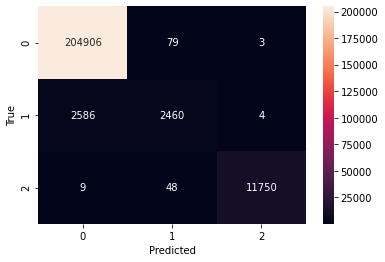

In [27]:
#confusion matrix
cf_matrix = confusion_matrix(y_test, y_predict, labels = [1,2,3])
sns.heatmap(cf_matrix, annot=True, fmt = 'g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [28]:
#finding feature importance
imp_features = pd.DataFrame(imp_features, index = X_train.columns, columns = ['importance']).sort_values('importance', ascending = False)
imp_features.head(10)

,importance
rec_prncp_per,0.16
recoveries,0.10
collection_recovery_fee,0.09
last_pymnt_d,0.08
total_rec_prncp,0.05
last_pymnt_amnt,0.04
last_pymnt_d_month,0.04
total_pymnt_inv,0.04
out_prncp,0.03
total_pymnt,0.03


## SMOTE for balancing the data

In [29]:
Counter(y_train)

Counter({3.0: 35421, 1.0: 614962, 2.0: 15151})

In [30]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train_encoded, y_train)

In [31]:
#training, predicting, feature importance  
y_predict, imp_features = training_predicting(X_train, X_test_encoded, y_train, 20, imp_features = True)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  4.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.4s finished


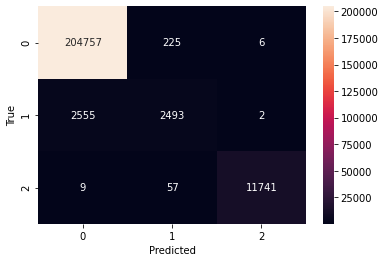

In [32]:
#confusion matrix
cf_matrix = confusion_matrix(y_test, y_predict, labels = [1,2,3])
sns.heatmap(cf_matrix, annot=True, fmt = 'g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#### I would like your thoughts on how to improve this model's False Negative problem